# Arvato Clustering Analysis and Classification

## 1.Business and data understanding

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

There are four data files associated with this project:

Udacity_AZDIAS_052018.csv: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).<br>
Udacity_CUSTOMERS_052018.csv: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).<br>
Udacity_MAILOUT_052018_TRAIN.csv: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).<br>
Udacity_MAILOUT_052018_TEST.csv: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).<br>

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the .csv data files in this project that they're semicolon (;) delimited, so an additional argument in the read_csv() call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.



In [1]:
#imports 
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick 
import matplotlib.dates as mdates
from matplotlib.ticker import PercentFormatter, FuncFormatter
%matplotlib inline
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)
from cycler import cycler
import os
import seaborn as sns
sns.set()
import warnings
import pickle

from sklearn.preprocessing import StandardScaler, LabelEncoder,OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, auc

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from xgboost import XGBClassifier

warnings.filterwarnings('ignore')

# environment settings
pd.set_option('display.max_column',None)
pd.set_option('display.max_rows',None)

In [4]:
import session_info
session_info.show()

## 2. Customer Segmentation

In [2]:
os.getcwd()

'/Users/i569947/Documents/Github_personal/arvato_customers_analysis/notebooks'

In [3]:
os.chdir('..')

In [7]:
population = pd.read_csv(os.getcwd()+'/src/data/raw_data/Udacity_AZDIAS_052018.csv', sep=';')

In [8]:
customers = pd.read_csv(os.getcwd()+'/src/data/raw_data/Udacity_CUSTOMERS_052018.csv', sep=';')

In [9]:
population.shape

(891221, 366)

In [10]:
population.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [13]:
#check for duplicate lines
population['LNR'].nunique()

891221

In [14]:
customers.shape

(191652, 369)

In [15]:
customers['LNR'].nunique()

191652

In [16]:
population.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGE

In [17]:
#check the common columns
common_columns = set(population.columns).intersection(set(customers.columns))
print(len(list(common_columns)))

366


### 2.1.How to perform the analysis 

So we have 2 datasets - 1 on the general population, and 1 on the customers of Arvato. We want to segment the general population into segments/clusters and determine to which clusters the customers of Arvato belong to -> in this way we will be able to understand which are the characteristics that outline potential customers of Arvato, understanding which are the features that describe the current customer base. <br>
In order to do that, we will perform as algorithms K-means or DBSCAN - we will create the clusters using the whole population dataset, and then we will see to which cluster the customers are assigned to, based on the common features with the general population division.<br>

Before that, we are facing a very huge number of features: 366 for general population and 369 for customers. We need to perform PCA to reduce the number of features. However, before that, there are some basic feature engineering steps we will perform, that could additionally reduce the number of features.

1. Removing feautures with predominantly missing values
2. Check for constant and duplicate features - to be removed
3. EDA of the variables - missing data, categorical variables, cardinality/rare labels, outliers
4. Feature Engineering
- computing missing data
- categorical variables encoding 
5. Feature Scaling
6. PCA - dimensionality reduction

Feature selection - we will not perform at this point, since this is an Unsupervised ML task and we will perform PCA. 

### 2.2. Check columns with predominantly missing data

Text(0.5, 1.0, 'Features with % missing values')

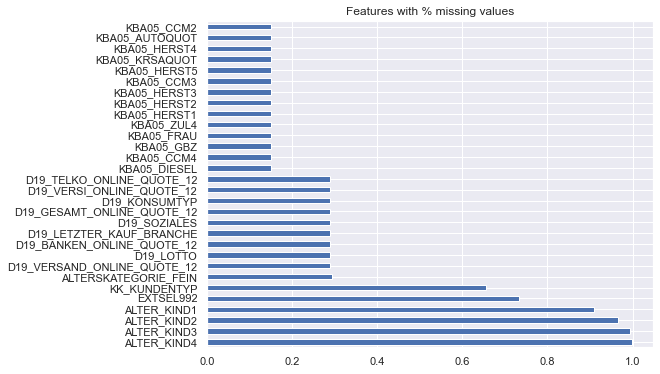

In [17]:
#check for null values
missing_values = population.isnull().sum()/population.shape[0]
missing_values.sort_values(ascending=False,inplace=True)

fig, ax = plt.subplots(figsize=(8,6))
missing_values.head(30).plot(kind='barh')
plt.title('Features with % missing values')

In [15]:
#check for null values
missing_values2 = customers.isnull().sum()/customers.shape[0]
missing_values2.sort_values(ascending=False,inplace=True)
missing_values2.head(30)

ALTER_KIND4        0.998769
ALTER_KIND3        0.993347
ALTER_KIND2        0.973389
ALTER_KIND1        0.938607
KK_KUNDENTYP       0.584064
EXTSEL992          0.444989
KBA05_KRSOBER      0.292092
KBA05_KRSHERST1    0.292092
KBA05_GBZ          0.292092
KBA05_HERST1       0.292092
KBA05_HERST2       0.292092
KBA05_HERST3       0.292092
KBA05_HERST4       0.292092
KBA05_HERST5       0.292092
KBA05_KRSAQUOT     0.292092
KBA05_KRSVAN       0.292092
KBA05_KRSHERST2    0.292092
KBA05_KRSKLEIN     0.292092
KBA05_DIESEL       0.292092
KBA05_KRSZUL       0.292092
KBA05_KW1          0.292092
KBA05_KW2          0.292092
KBA05_KW3          0.292092
KBA05_FRAU         0.292092
KBA05_CCM2         0.292092
KBA05_CCM4         0.292092
KBA05_ANTG1        0.292092
MOBI_REGIO         0.292092
KBA05_ALTER1       0.292092
KBA05_ALTER2       0.292092
dtype: float64

The 4 columns ALTER_KIND1 to ALTER_KIND4 have predominantly missing values from both datasets - above 90%, and additional two columns with more than half missing values (KK_KUNDENTYP,EXTSEL992) so we will remove the columns from both datasets.

In [18]:
population.drop(columns={'ALTER_KIND1','ALTER_KIND2','ALTER_KIND3','ALTER_KIND4','EXTSEL992','KK_KUNDENTYP'},axis=1,inplace=True)

In [19]:
customers.drop(columns={'ALTER_KIND1','ALTER_KIND2','ALTER_KIND3','ALTER_KIND4','EXTSEL992','KK_KUNDENTYP'},axis=1,inplace=True)

In [20]:
information = pd.read_excel(os.getcwd()+'/src/data/raw_data/DIAS Information Levels - Attributes 2017.xlsx',header = 1)

In [21]:
information.head()

,Unnamed: 0,Information level,Attribute,Description,Additional notes
0,NaN,Person,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,NaN,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,Person,ANREDE_KZ,gender,NaN
3,NaN,Person,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,Person,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


In [22]:
descr = pd.read_excel(os.getcwd()+'/src/data/raw_data/DIAS Attributes - Values 2017.xlsx',header = 0)

In [23]:
descr.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly


### 2.2. Check for columns with constant and duplicated features

In [22]:
#find columns with the same value
col_list = []
for col in population.columns:
    if population[col].nunique()==1:
        col_list.append(col)

In [67]:
col_list

[]

In [68]:
#find columns with the same value
col_list_cust = []
for col in customers.columns:
    if customers[col].nunique()==1:
        col_list_cust.append(col)

In [69]:
col_list_cust

[]

There are no constant features in the datasets. 

#### Check for quasi-constant features

In [70]:
#check whether the rest of the categories have only 2 values
col_list_quasi = []
for col in population.columns:
    if population[col].nunique()==2:
        col_list_quasi.append(col)

col_list_quasi 

['DSL_FLAG',
 'GREEN_AVANTGARDE',
 'HH_DELTA_FLAG',
 'KONSUMZELLE',
 'OST_WEST_KZ',
 'SOHO_KZ',
 'UNGLEICHENN_FLAG',
 'ANREDE_KZ']

In [71]:
#check whether the rest of the categories have only 2 values
col_list_quasi_c = []
for col in customers.columns:
    if customers[col].nunique()==2:
        col_list_quasi_c.append(col)

col_list_quasi_c

['DSL_FLAG',
 'GREEN_AVANTGARDE',
 'HH_DELTA_FLAG',
 'KONSUMZELLE',
 'OST_WEST_KZ',
 'SOHO_KZ',
 'UNGLEICHENN_FLAG',
 'CUSTOMER_GROUP',
 'ONLINE_PURCHASE',
 'ANREDE_KZ']

In [72]:
population['ANREDE_KZ'].value_counts()

2    465305
1    425916
Name: ANREDE_KZ, dtype: int64

In [73]:
customers['ONLINE_PURCHASE'].value_counts()

0    174356
1     17296
Name: ONLINE_PURCHASE, dtype: int64

#### Check for features that have the same values

In [23]:
# check for duplicated features in the whole dataset:

# create an empty dictionary, where we will store 
# the groups of duplicates
duplicated_feat_pairs = {}

# create an empty list to collect features
# that were found to be duplicated
_duplicated_feat = []


# iterate over every feature in our dataset:
for i in range(0, len(population.columns)):
    
    # this bit helps me understand where the loop is at:
    if i % 10 == 0:  
        print(i)
    
    # choose 1 feature:
    feat_1 = population.columns[i]
    
    # check if this feature has already been identified
    # as a duplicate of another one. If it was, it should be stored in
    # our _duplicated_feat list.
    
    # If this feature was already identified as a duplicate, we skip it, if
    # it has not yet been identified as a duplicate, then we proceed:
    if feat_1 not in _duplicated_feat:
    
        # create an empty list as an entry for this feature in the dictionary:
        duplicated_feat_pairs[feat_1] = []

        # now, iterate over the remaining features of the dataset:
        for feat_2 in population.columns[i + 1:]:

            # check if this second feature is identical to the first one
            if population[feat_1].equals(population[feat_2]):

                # if it is identical, append it to the list in the dictionary
                duplicated_feat_pairs[feat_1].append(feat_2)
                
                # and append it to our monitor list for duplicated variables
                _duplicated_feat.append(feat_2)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350


In [75]:
len(_duplicated_feat)

1

In [76]:
# print the features with its duplicates

# iterate over every feature in our dict:
for feat in duplicated_feat_pairs.keys():
    
    # if it has duplicates, the list should not be empty:
    if len(duplicated_feat_pairs[feat]) > 0:

        # print the feature and its duplicates:
        print(feat, duplicated_feat_pairs[feat])
        print()

KBA13_FAB_SONSTIGE ['KBA13_HERST_SONST']



In [48]:
# check for duplicated features in the whole dataset:

# create an empty dictionary, where we will store 
# the groups of duplicates
duplicated_feat_pairs = {}

# create an empty list to collect features
# that were found to be duplicated
_duplicated_feat = []


# iterate over every feature in our dataset:
for i in range(0, len(customers.columns)):
    
    # this bit helps me understand where the loop is at:
    if i % 10 == 0:  
        print(i)
    
    # choose 1 feature:
    feat_1 = customers.columns[i]
    
    # check if this feature has already been identified
    # as a duplicate of another one. If it was, it should be stored in
    # our _duplicated_feat list.
    
    # If this feature was already identified as a duplicate, we skip it, if
    # it has not yet been identified as a duplicate, then we proceed:
    if feat_1 not in _duplicated_feat:
    
        # create an empty list as an entry for this feature in the dictionary:
        duplicated_feat_pairs[feat_1] = []

        # now, iterate over the remaining features of the dataset:
        for feat_2 in customers.columns[i + 1:]:

            # check if this second feature is identical to the first one
            if customers[feat_1].equals(customers[feat_2]):

                # if it is identical, append it to the list in the dictionary
                duplicated_feat_pairs[feat_1].append(feat_2)
                
                # and append it to our monitor list for duplicated variables
                _duplicated_feat.append(feat_2)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360


In [49]:
len(_duplicated_feat)

1

In [50]:
# print the features with its duplicates

# iterate over every feature in our dict:
for feat in duplicated_feat_pairs.keys():
    
    # if it has duplicates, the list should not be empty:
    if len(duplicated_feat_pairs[feat]) > 0:

        # print the feature and its duplicates:
        print(feat, duplicated_feat_pairs[feat])
        print()

KBA13_FAB_SONSTIGE ['KBA13_HERST_SONST']



I will remove the duplicated feature, since it can lead to multi-colinearity. 

In [24]:
population.drop(columns={'KBA13_HERST_SONST'},axis=1,inplace=True)
customers.drop(columns={'KBA13_HERST_SONST'},axis=1,inplace=True)

### 2.3.Exploratory data analysis of the variables

In [25]:
population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 359 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(260), int64(93), object(6)
memory usage: 2.4+ GB


In [26]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 362 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(260), int64(94), object(8)
memory usage: 529.3+ MB


In [27]:
information['Information level'].unique()

array(['Person', 'Household', 'Building', 'Microcell (RR4_ID)',
       'Microcell (RR3_ID)', '125m x 125m Grid', 'Postcode ', 'RR1_ID',
       'PLZ8', 'Community', nan], dtype=object)

In [28]:
information['Information level'].head()

0    Person
1    Person
2    Person
3    Person
4    Person
Name: Information level, dtype: object

#### 2.3.1.Person characteristics

In [29]:
population['ALTERSKATEGORIE_GROB'].value_counts()

3    358533
4    228510
2    158410
1    142887
9      2881
Name: ALTERSKATEGORIE_GROB, dtype: int64

In [30]:
def function_to_plot_sim(col):
    new_df = pd.DataFrame()
    pop_summary = population.groupby(col).agg({'LNR':'count'}).reset_index()
    pop_summary['source'] = 'general population'
    cust_summary = customers.groupby(col).agg({'LNR':'count'}).reset_index()
    cust_summary['source'] = 'arvato customers'
    new_df = new_df.append(pop_summary)
    new_df = new_df.append(cust_summary)
    
    descr_pd = descr[descr['Attribute'] == col].copy()
    
    fig, ax = plt.subplots(figsize=(12,8))
    sns.barplot(x =col, y = 'LNR', data = new_df, hue = 'source', ax = ax) 
    plt.title(f'Number of observations for column {col} ', size = 20)
    plt.legend()
    plt.show();
    return descr_pd

In [31]:
population.describe(include='object')

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
count,792242,792242,792242,634108,798073,798073
unique,45,19,43,35,5162,2
top,6B,8,51,D19_UNBEKANNT,1992-02-10 00:00:00,W
freq,56672,78023,77576,195338,383738,629528


In [32]:
customers.describe(include='object')

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ,PRODUCT_GROUP,CUSTOMER_GROUP
count,141224,141224,141224,143955,141725,141725,191652,191652
unique,45,19,43,35,3034,2,3,2
top,2D,2,14,D19_UNBEKANNT,1992-02-10 00:00:00,W,COSMETIC_AND_FOOD,MULTI_BUYER
freq,11208,17574,14708,31910,64744,130382,100860,132238


There are 6 categorical columns within the general population dataset, that we need to handle -> we need to encode them into numerical values.
However, all the fifth have huge number of values, that is a problem. We will revise them separately to see how to handle them.

In [33]:
population['CAMEO_INTL_2015'].isna().sum()/population.shape[0]

0.11105999522004081

- CAMEO_DEU_2015 - 45 variables, which cannot be combined in a way to preserve to meaning. It is some customized detailed classification. I will drop this categorical variable. 

- CAMEO_INTL_2015 - 43 variables. There is no description in the files -> we are dropping it. 

- D19_LETZTER_KAUF_BRANCHE (35 variables)  - no description in the files, we are dropping it.

#### Transforming CAMEO_DEUG_2015 to less values -> to ordinal variable

In [34]:
### Transforming CAMEO_DEUG_2015 to less values
population['CAMEO_DEUG_2015'].fillna(-1,axis=0, inplace=True)
#population['CAMEO_DEUG_2015'] = population['CAMEO_DEUG_2015'].astype(int)

In [35]:
population['CAMEO_DEUG_2015'].fillna(-1,axis=0, inplace=True)
population['CAMEO_DEUG_2015'] = np.where(population['CAMEO_DEUG_2015']=='X',-1,population['CAMEO_DEUG_2015'])

In [36]:
population['CAMEO_DEUG_2015'] = population['CAMEO_DEUG_2015'].astype(int)

In [37]:
population['CAMEO_DEUG_2015'].value_counts()

 8    134441
 9    108177
 6    105874
 4    103912
-1     99352
 3     86779
 2     83231
 7     77933
 5     55310
 1     36212
Name: CAMEO_DEUG_2015, dtype: int64

One option is to code the CAMEO_DEUG_2015 in the following 4 classes: upper class, middleclass, working class, unknown. The other option, since the classes are from 1 to 9, as 1 for the higher upper class, and 9 for the working class, we could look at the variable as numerical ordinal variable, so there is no need to transform it additionally after the changes we already performed.

In [38]:
#performing same changes in the customer dataset
customers['CAMEO_DEUG_2015'].fillna(-1,axis=0, inplace=True)
customers['CAMEO_DEUG_2015'] = np.where(customers['CAMEO_DEUG_2015']=='X',-1,customers['CAMEO_DEUG_2015'])
customers['CAMEO_DEUG_2015'] = customers['CAMEO_DEUG_2015'].astype(int)

In [39]:
customers['CAMEO_DEUG_2015'].value_counts()

-1    50554
 2    23484
 4    22064
 6    18717
 3    18390
 1    16778
 8    13049
 5    11666
 7    10558
 9     6392
Name: CAMEO_DEUG_2015, dtype: int64

In [40]:
population['OST_WEST_KZ'].value_counts()

W    629528
O    168545
Name: OST_WEST_KZ, dtype: int64

In [41]:
population.drop(columns = {'CAMEO_DEU_2015','CAMEO_INTL_2015','D19_LETZTER_KAUF_BRANCHE'},axis=1,inplace=True)
customers.drop(columns = {'CAMEO_DEU_2015','CAMEO_INTL_2015','D19_LETZTER_KAUF_BRANCHE'},axis=1,inplace=True)

In [44]:
population.describe(include='object')

,EINGEFUEGT_AM,OST_WEST_KZ
count,798073,798073
unique,5162,2
top,1992-02-10 00:00:00,W
freq,383738,629528


In [45]:
customers.describe(include='object')

,EINGEFUEGT_AM,OST_WEST_KZ,PRODUCT_GROUP,CUSTOMER_GROUP
count,141725,141725,191652,191652
unique,3034,2,3,2
top,1992-02-10 00:00:00,W,COSMETIC_AND_FOOD,MULTI_BUYER
freq,64744,130382,100860,132238


OST_WEST_KZ - will be transformed to Dummy variable with one hot encoding.
EINGEFUEGT_AM - we will extract the year and keep it as numerical value.

The timestamp column 'EINGEFUEGT_AM' will be deleted, since we do not know what this variable mean -> no description given.

In [42]:
population.drop(columns = {'EINGEFUEGT_AM'},axis=1,inplace=True)
customers.drop(columns = {'EINGEFUEGT_AM'},axis=1,inplace=True)

Since most of the unknown values are coded with -1 values, I will use within a pipeline Simple Imputer to populate the missing values with ‘constant’ -1 strategy. However, before that, we need to unify all missing values, to be coded as - 1 /currently they are coded as -1, 0, 9/. <br>
For the population dataset, there is left only 1 categorical variable, with only 2 values, that we will encode as dummy variable, with One-hot encoding, again in a pipeline. The additional columns for the customers dataset will be omitted when running the clustering, since they are not present in the population dataset.

The following columns have 9 as value that is meaningful - replace just 0 values with -1 :
- ALTERSKATEGORIE_GROB, ALTER_HH, CAMEO_DEUG_2015, D19_BANKEN_DATUM, D19_BANKEN_OFFLINE_DATUM, D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12, D19_GESAMT_DATUM, D19_GESAMT_OFFLINE_DATUM, D19_GESAMT_ONLINE_DATUM, D19_GESAMT_ONLINE_QUOTE_12, D19_KONSUMTYP, D19_TELKO_DATUM, D19_TELKO_OFFLINE_DATUM, D19_TELKO_ONLINE_DATUM, D19_VERSAND_DATUM, D19_VERSAND_OFFLINE_DATUM, D19_VERSAND_ONLINE_DATUM, D19_VERSAND_ONLINE_QUOTE_12, GFK_URLAUBERTYP, HAUSHALTSSTRUKTUR, LP_FAMILIE_FEIN, 
LP_FAMILIE_GROB,LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB, LP_STATUS_FEIN, LP_STATUS_GROB



The following columns have 0 as value that is meaningful - replace just 9 values with -1 :
- BIP_FLAG, GREEN_AVANTGARDE, SOHO_FLAG,SHOPPER_TYP 

In [43]:
#replace 0 values with -1: 

col_list = ['ALTERSKATEGORIE_GROB', 'ALTER_HH', 'CAMEO_DEUG_2015', 'D19_BANKEN_DATUM', 'D19_BANKEN_OFFLINE_DATUM',
            'D19_BANKEN_ONLINE_DATUM','D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_DATUM', 'D19_GESAMT_OFFLINE_DATUM',
            'D19_GESAMT_ONLINE_DATUM', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP', 'D19_TELKO_DATUM', 'D19_TELKO_OFFLINE_DATUM', 
            'D19_TELKO_ONLINE_DATUM', 'D19_VERSAND_DATUM', 'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM',
            'D19_VERSAND_ONLINE_QUOTE_12', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 
'LP_FAMILIE_GROB','LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB']

for col in col_list:
    population[col] = np.where(population[col]==0,-1,population[col])
    customers[col] = np.where(customers[col]==0,-1,customers[col])

In [44]:
#replace 9 values with -1: 

col_list_2 = ['GREEN_AVANTGARDE', 'SHOPPER_TYP']

for col in col_list_2:
    population[col] = np.where(population[col]==9,-1,population[col])
    customers[col] = np.where(customers[col]==9,-1,customers[col])

#### Exploring some of the main distinguishers within the customers of Arvato

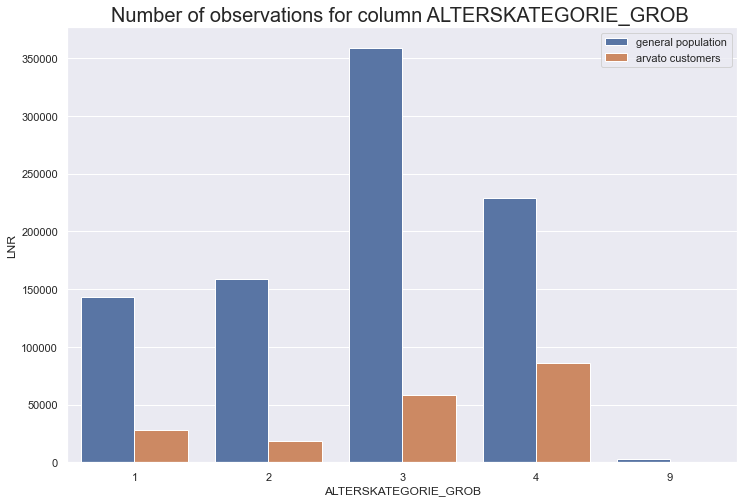

,Attribute,Description,Value,Meaning
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,ALTERSKATEGORIE_GROB,age classification through prename analysis,1,< 30 years
7,ALTERSKATEGORIE_GROB,age classification through prename analysis,2,30 - 45 years
8,ALTERSKATEGORIE_GROB,age classification through prename analysis,3,46 - 60 years
9,ALTERSKATEGORIE_GROB,age classification through prename analysis,4,> 60 years
10,ALTERSKATEGORIE_GROB,age classification through prename analysis,9,uniformly distributed


In [48]:
function_to_plot_sim('ALTERSKATEGORIE_GROB')

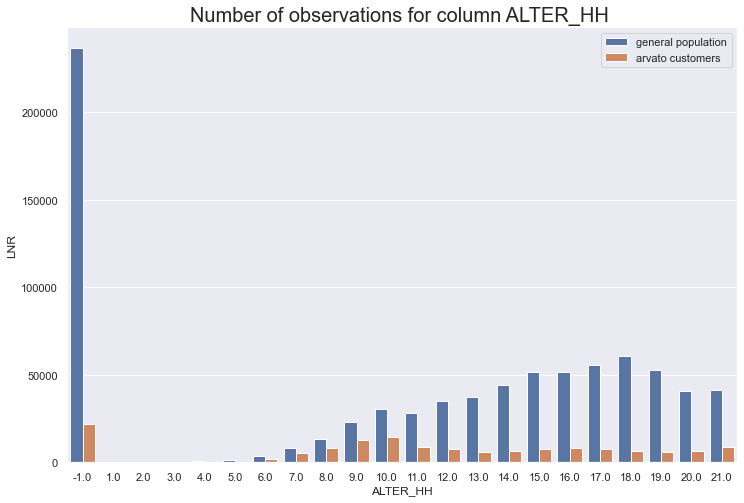

,Attribute,Description,Value,Meaning
11,ALTER_HH,main age within the household,0,unknown / no main age detectable
12,ALTER_HH,main age within the household,1,01.01.1895 bis 31.12.1899
13,ALTER_HH,main age within the household,2,01.01.1900 bis 31.12.1904
14,ALTER_HH,main age within the household,3,01.01.1905 bis 31.12.1909
15,ALTER_HH,main age within the household,4,01.01.1910 bis 31.12.1914
16,ALTER_HH,main age within the household,5,01.01.1915 bis 31.12.1919
17,ALTER_HH,main age within the household,6,01.01.1920 bis 31.12.1924
18,ALTER_HH,main age within the household,7,01.01.1925 bis 31.12.1929
19,ALTER_HH,main age within the household,8,01.01.1930 bis 31.12.1934
20,ALTER_HH,main age within the household,9,01.01.1935 bis 31.12.1939


In [47]:
function_to_plot_sim('ALTER_HH')

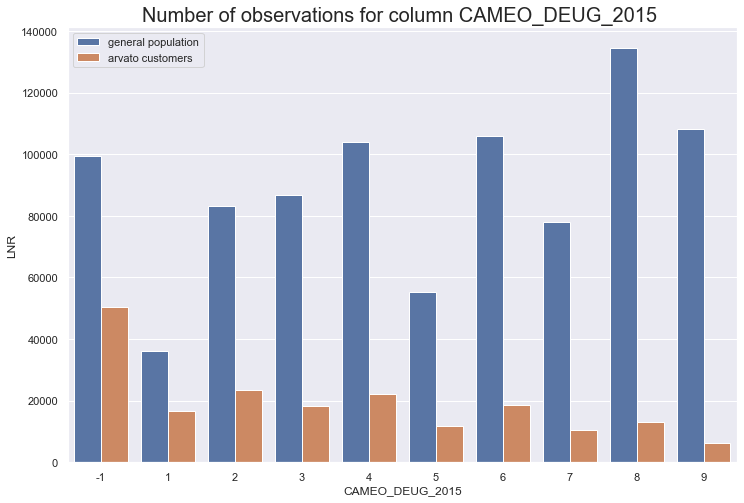

,Attribute,Description,Value,Meaning
51,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown
52,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,1,upper class
53,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,2,upper middleclass
54,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,3,established middleclasse
55,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,4,consumption-oriented middleclass
56,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,5,active middleclass
57,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,6,low-consumption middleclass
58,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,7,lower middleclass
59,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,8,working class
60,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,9,urban working class


In [59]:
function_to_plot_sim('CAMEO_DEUG_2015')

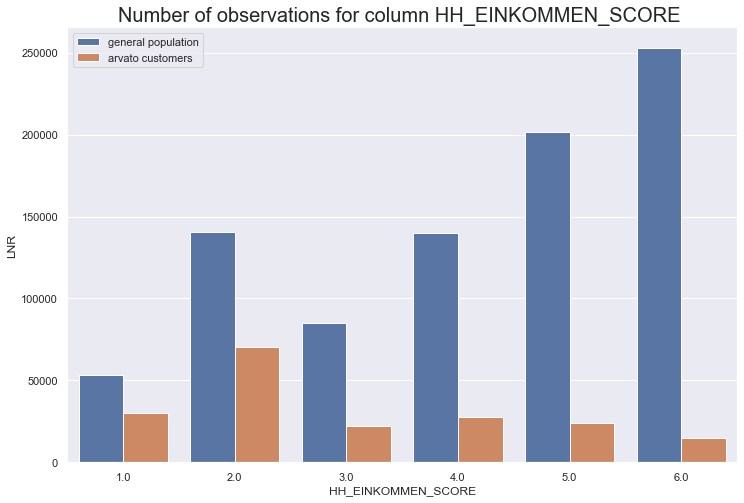

,Attribute,Description,Value,Meaning
749,HH_EINKOMMEN_SCORE,estimated household net income,"-1, 0",unknown
750,HH_EINKOMMEN_SCORE,estimated household net income,1,highest income
751,HH_EINKOMMEN_SCORE,estimated household net income,2,very high income
752,HH_EINKOMMEN_SCORE,estimated household net income,3,high income
753,HH_EINKOMMEN_SCORE,estimated household net income,4,average income
754,HH_EINKOMMEN_SCORE,estimated household net income,5,lower income
755,HH_EINKOMMEN_SCORE,estimated household net income,6,very low income


In [60]:
function_to_plot_sim('HH_EINKOMMEN_SCORE')

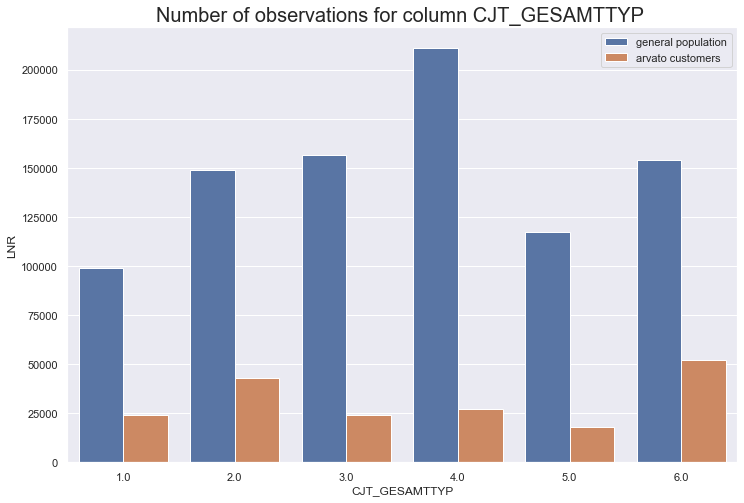

,Attribute,Description,Value,Meaning
131,CJT_GESAMTTYP,customer journey typology,0,unknown
132,CJT_GESAMTTYP,customer journey typology,1,Advertising- and Consumptionminimalist
133,CJT_GESAMTTYP,customer journey typology,2,Advertising- and Consumptiontraditionalist
134,CJT_GESAMTTYP,customer journey typology,3,advertisinginterested Store-shopper
135,CJT_GESAMTTYP,customer journey typology,4,advertisinginterested Online-shopper
136,CJT_GESAMTTYP,customer journey typology,5,Advertising- and Cross-Channel-Enthusiast
137,CJT_GESAMTTYP,customer journey typology,6,Advertising-Enthusiast with restricted Cross-C...


In [49]:
function_to_plot_sim('CJT_GESAMTTYP')

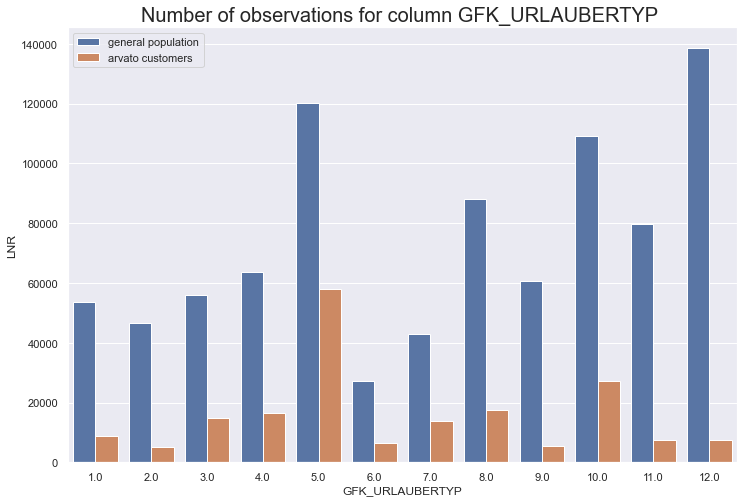

,Attribute,Description,Value,Meaning
712,GFK_URLAUBERTYP,vacation habits,1,Event travelers
713,GFK_URLAUBERTYP,vacation habits,2,Family-oriented vacationists
714,GFK_URLAUBERTYP,vacation habits,3,Winter sportspeople
715,GFK_URLAUBERTYP,vacation habits,4,Culture lovers
716,GFK_URLAUBERTYP,vacation habits,5,Nature fans
717,GFK_URLAUBERTYP,vacation habits,6,Hiker
718,GFK_URLAUBERTYP,vacation habits,7,Golden ager
719,GFK_URLAUBERTYP,vacation habits,8,Homeland-connected vacationists
720,GFK_URLAUBERTYP,vacation habits,9,Package tour travelers
721,GFK_URLAUBERTYP,vacation habits,10,Connoisseurs


In [50]:
function_to_plot_sim('GFK_URLAUBERTYP')


__Age__: Based on the person characteristics, we see that the main share of the customers of Arvato fall into the group above 60 years, while the data for the general population shows that group 46-60 years as biggest. Column Main age within Household shows also a difference: the biggest group of Arvato customers are between 01.01.1935 and 31.12.1944, while for the general population are between 01.01.1965 to 31.12.1989. This shows a significant difference within the Age of the customers of Arvato, vs. the general population.

__Income__: The arvato'customers fall more often into middle-class categories, with the biggest group by income - very high income, while the general population distribution shows more people as working class, with low income.
The biggest groups from the general population are the single low-income earners, while from Arvato customers: top earners from retirement age from multiperson households, followed by top earner-couples of higher age, single top earners of higher age, independant persons of higher age and homeowners at retirement age from multiperson households.

__Vacation habits__ reveal that the biggest group of Arvato customers are nature fans, followed by Connoisseurs, while the biggest group from the general population goes without vacation, followed also by the nature fans.

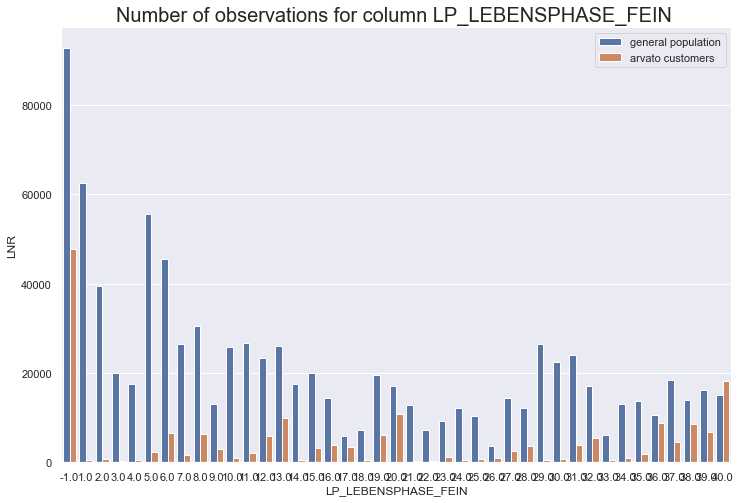

,Attribute,Description,Value,Meaning
1914,LP_LEBENSPHASE_FEIN,lifestage fine,1,single low-income earners of younger age
1915,LP_LEBENSPHASE_FEIN,lifestage fine,2,single low-income earners of middle age
1916,LP_LEBENSPHASE_FEIN,lifestage fine,3,single average earners of younger age
1917,LP_LEBENSPHASE_FEIN,lifestage fine,4,single average earners of middle age
1918,LP_LEBENSPHASE_FEIN,lifestage fine,5,single low-income earners of advanced age
1919,LP_LEBENSPHASE_FEIN,lifestage fine,6,single low-income earners at retirement age
1920,LP_LEBENSPHASE_FEIN,lifestage fine,7,single average earners of advanced age
1921,LP_LEBENSPHASE_FEIN,lifestage fine,8,single average earners at retirement age
1922,LP_LEBENSPHASE_FEIN,lifestage fine,9,single independant persons
1923,LP_LEBENSPHASE_FEIN,lifestage fine,10,wealthy single homeowners


In [52]:
pd.set_option('display.max_columns', None)  
function_to_plot_sim('LP_LEBENSPHASE_FEIN')

### 2.4. Preprocessing tasks before Unsupervised learning

The pipeline will handle the following tasks: 
- computing missing data
- categorical variables encoding 
- Feature Scaling
- PCA - dimensionality reduction

#### 2.4.1.Categorical variable encoding

In [53]:
customer = customers.drop(columns={'CUSTOMER_GROUP','ONLINE_PURCHASE','PRODUCT_GROUP'},axis=1).copy()

In [54]:
population.describe(include='object')

,OST_WEST_KZ
count,798073
unique,2
top,W
freq,629528


In [55]:
population_enc = pd.get_dummies(population['OST_WEST_KZ'])

In [56]:
population_enc.head()

,O,W
0,0,0
1,0,1
2,0,1
3,0,1
4,0,1


In [57]:
population_enc.shape

(891221, 2)

In [58]:
pop = pd.merge(population,population_enc,right_index=True,left_index=True)

In [59]:
pop.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUM

In [60]:
pop.columns

Index(['LNR', 'AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ALTERSKATEGORIE_FEIN',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_KINDER', 'ANZ_PERSONEN',
       'ANZ_STATISTISCHE_HAUSHALTE',
       ...
       'VK_DISTANZ', 'VK_ZG11', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'WOHNLAGE',
       'ZABEOTYP', 'ANREDE_KZ', 'ALTERSKATEGORIE_GROB', 'O', 'W'],
      dtype='object', length=357)

In [62]:
pop.drop(columns={'OST_WEST_KZ'},axis=1,inplace=True)

In [63]:
cust_enc = pd.get_dummies(customer['OST_WEST_KZ'])
cust = pd.merge(customer,cust_enc,right_index=True,left_index=True)

In [64]:
cust.drop(columns={'OST_WEST_KZ'},axis=1,inplace=True)

#### 2.4.2.Imputing missing data

In [65]:
imputer = SimpleImputer(strategy = 'constant',fill_value = -1)

In [66]:
pop_imputed = imputer.fit_transform(pop)

In [67]:
pop_imputed = pd.DataFrame(pop_imputed,columns=pop.columns)
pop_imputed = pop_imputed.astype(float)

In [68]:
pop_imputed.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUM

In [69]:
cust_imputed = imputer.fit_transform(cust)
cust_imputed = pd.DataFrame(cust_imputed,columns=cust.columns)
cust_imputed = cust_imputed.astype(float)

In [70]:
cust_imputed.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUM

Before scaling we will remove the LNR column - as we know this is no valuable information.

In [71]:
pop_imputed.drop(columns={'LNR'},axis=1,inplace=True)
cust_imputed.drop(columns={'LNR'},axis=1,inplace=True)

### 2.4.3.Feature Scaling

In [72]:
scaler = StandardScaler()

In [73]:
pop_scaled = scaler.fit_transform(pop_imputed)

In [74]:
pop_scaled = pd.DataFrame(pop_scaled,columns = pop_imputed.columns)

In [75]:
pop_scaled.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS

In [76]:
cust_scaled = scaler.fit_transform(cust_imputed)
cust_scaled = pd.DataFrame(cust_scaled, columns = cust_imputed.columns)

In [77]:
os.getcwd()

'/Users/i569947/Documents/Github_personal/arvato_customers_analysis'

In [78]:
pop_scaled.to_pickle(os.getcwd()+"/src/data/processed/population_processed.pkl")
cust_scaled.to_pickle(os.getcwd()+"/src/data/processed/customer_processed.pkl")

#### 2.4.4. PCA

In [79]:
pca = PCA()

In [80]:
pop_pca = pca.fit(pop_scaled)

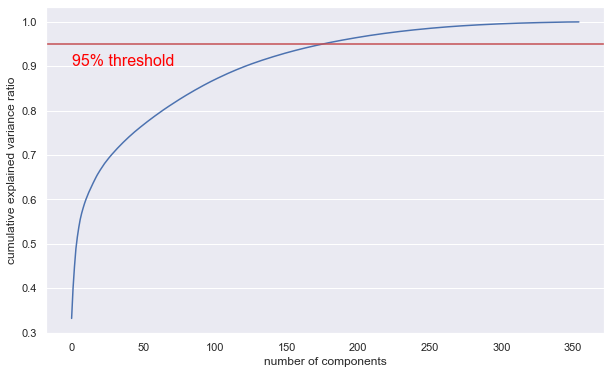

In [83]:
plt.figure(figsize=(10,6))

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance ratio')

plt.axhline(y=0.95, color='r')
plt.text(0.5, 0.9, '95% threshold', color = 'red', fontsize=16)

plt.grid(axis='x')

In [84]:
total_explained_variance = pca.explained_variance_ratio_.cumsum()
n_over_95 = len(total_explained_variance[total_explained_variance >= .95])

In [85]:
n_to_reach_95 = pop_scaled.shape[1]-n_over_95 + 1

print('Number features: {}\tTotal Variance Explained: {}'.format(n_to_reach_95, total_explained_variance[n_to_reach_95-1]))

Number features: 176	Total Variance Explained: 0.9500856774706659


In [86]:
n_over_90 = len(total_explained_variance[total_explained_variance >= .90])
n_to_reach_90 = pop_scaled.shape[1]-n_over_90 + 1

print('Number features: {}\tTotal Variance Explained: {}'.format(n_to_reach_90, total_explained_variance[n_to_reach_90-1]))

Number features: 123	Total Variance Explained: 0.9011842917704663


__With 176 features we obtain 95% of the variance. With 123 features we preserve 90% of the variance.__


In [87]:
#We will go with preserving 95% of the variance
def pca_reduction(df, n_components):
    """
    Perform PCA dimension reduction to dataset
    Input: 
    df: dataframe
    n_components: Number of components for PCA
    
    Output:
    df_reduced: PCA applied dataset (DataFrame)
    pca: PCA object
    """
    # PCA
    pca = PCA(n_components=n_components)
    # fit and transform of PCA
    df_reduced = pd.DataFrame(pca.fit_transform(df), columns=["PC"+str(i) for i in range(n_components)])
    return df_reduced, pca

In [88]:
population_reduced, population_pca = pca_reduction(pop_scaled, n_to_reach_95)

In [89]:
population_reduced.shape

(891221, 176)

In [90]:
population_pca

PCA(n_components=176)

In [91]:
population_pca.components_

array([[-0.01336452, -0.02996015, -0.03144785, ..., -0.01053088,
        -0.01351652, -0.04676074],
       [-0.01255983,  0.06313583, -0.08322704, ...,  0.00788081,
         0.01413416, -0.02170465],
       [ 0.03976103, -0.06399235,  0.0054708 , ...,  0.04910415,
        -0.01938863, -0.00472956],
       ...,
       [-0.01242643,  0.00946451, -0.01680314, ..., -0.04407581,
         0.01756376, -0.00455728],
       [ 0.02869345,  0.00507383, -0.01555372, ..., -0.06572759,
         0.04988747, -0.04954951],
       [ 0.00452766, -0.01649908,  0.04772357, ...,  0.03139232,
        -0.06267705,  0.0387027 ]])

In [92]:
customer_reduced, customer_pca = pca_reduction(cust_scaled, n_to_reach_95)

In [94]:
customer_reduced.shape

(191652, 176)

#### Getting feature importance
PCA is also important to determine the feature importance. The first function creates a matrix which shows feature weights for each principal components.
In the final dataframe, principal components are sorted according to importance. So, PC 0 is the most important one.

In [95]:
def pca_feature_importance(pca, df):
    """
    Create a matrix that gives feature weights for every principal components
    Input: 
    pca: PCA object for df
    df: Demographic dataset (DataFrame)
    Output:
    fet_import_matrix: feature importance for each principal component matrix (DataFrame)
    """
    # number of components
    n_comp= pca.n_components_
    # index column of dataframe
    idx=["PC"+str(i) for i in range(n_comp)]
    # create dataframe
    fet_import_matrix=pd.DataFrame((pca.components_), columns=df.columns, index=idx)
    return fet_import_matrix

In [96]:
population_pca_feature_importance = pca_feature_importance(population_pca, pop_scaled)

In [97]:
population_pca.get_feature_names_out()

array(['pca0', 'pca1', 'pca2', 'pca3', 'pca4', 'pca5', 'pca6', 'pca7',
       'pca8', 'pca9', 'pca10', 'pca11', 'pca12', 'pca13', 'pca14',
       'pca15', 'pca16', 'pca17', 'pca18', 'pca19', 'pca20', 'pca21',
       'pca22', 'pca23', 'pca24', 'pca25', 'pca26', 'pca27', 'pca28',
       'pca29', 'pca30', 'pca31', 'pca32', 'pca33', 'pca34', 'pca35',
       'pca36', 'pca37', 'pca38', 'pca39', 'pca40', 'pca41', 'pca42',
       'pca43', 'pca44', 'pca45', 'pca46', 'pca47', 'pca48', 'pca49',
       'pca50', 'pca51', 'pca52', 'pca53', 'pca54', 'pca55', 'pca56',
       'pca57', 'pca58', 'pca59', 'pca60', 'pca61', 'pca62', 'pca63',
       'pca64', 'pca65', 'pca66', 'pca67', 'pca68', 'pca69', 'pca70',
       'pca71', 'pca72', 'pca73', 'pca74', 'pca75', 'pca76', 'pca77',
       'pca78', 'pca79', 'pca80', 'pca81', 'pca82', 'pca83', 'pca84',
       'pca85', 'pca86', 'pca87', 'pca88', 'pca89', 'pca90', 'pca91',
       'pca92', 'pca93', 'pca94', 'pca95', 'pca96', 'pca97', 'pca98',
       'pca99', 'pca1

In [98]:
population_pca_feature_importance.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS

In [99]:
print(population_pca.explained_variance_ratio_)

[0.33179258 0.06762863 0.04897255 0.04043507 0.02649593 0.02143206
 0.01811551 0.01378009 0.01150895 0.01053521 0.00924183 0.00822364
 0.00783614 0.00710701 0.00700899 0.00671404 0.0065901  0.00632172
 0.00604574 0.00539152 0.00521984 0.00499923 0.0048377  0.00475526
 0.00422854 0.00416229 0.0040358  0.00395635 0.00373625 0.00364878
 0.00361553 0.00355845 0.0034084  0.00336209 0.00330712 0.00325677
 0.00324926 0.00314061 0.00311636 0.00306404 0.00299523 0.00293909
 0.00292742 0.00280978 0.00277095 0.00272734 0.00265124 0.00263552
 0.00262591 0.00260373 0.00256872 0.00254682 0.00250501 0.00250102
 0.00248129 0.002457   0.00241151 0.00239905 0.00235841 0.00235343
 0.00233407 0.00232225 0.00229185 0.00228077 0.00225892 0.00223252
 0.00217539 0.00216398 0.00215156 0.00213277 0.0021219  0.00210724
 0.00209005 0.00207451 0.00205926 0.00204943 0.00203556 0.00200324
 0.0019779  0.00194851 0.00194194 0.00193362 0.00191796 0.00189846
 0.00187107 0.0018584  0.0018429  0.00182835 0.00181449 0.0017

__So we see that PC0 is the PC component that explains the most variance, followed by PC1 and PC2.__ 

In [100]:
descr.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly


In [101]:
information.head()

,Unnamed: 0,Information level,Attribute,Description,Additional notes
0,NaN,Person,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,NaN,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,Person,ANREDE_KZ,gender,NaN
3,NaN,Person,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,Person,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


In [102]:
def most_important_features(pca_feature_importance_matrix, df, information, component_number):
    """
    Create a dataframe with the highest feature weights with feature description for spesific principal component
    
    Input: 
    pca_feature_importance_matrix: pca_feature_importance_matrix: PCA feature importance for each principal component matrix (DataFrame)
    df: DataFrame
    information: Dataset which includes descriptions and meanings of features
    component_number: number of the component (int)
    
    Output:
    pc_tops: top 5 positive and negative features with description and meaning for principal component given
    
    """
    # select top 5 and bottom 5 features from pca_feature_importance_matrix
    pc_tops=pd.DataFrame(pca_feature_importance_matrix.iloc[component_number].sort_values(ascending=False).iloc[[0,1,2,3,4,-5,-4,-3,-2,-1]])
    
    # merge pc_tops with attributes dataset
    pc_tops = pd.merge(left=pc_tops, right=information, how='left', left_on=pc_tops.index, right_on='Attribute')
    
    # set index attribute column
    pc_tops=pc_tops.set_index("Attribute").drop(columns={'Unnamed: 0','Information level'})
    
    return pc_tops

In [103]:
most_important_features(population_pca_feature_importance, pop_scaled, information, 0)

,PC0,Description,Additional notes
Attribute,,,
KOMBIALTER,0.061222,NaN,NaN
FINANZ_UNAUFFAELLIGER,0.040448,financial typology: unremarkable,NaN
FINANZ_ANLEGER,0.033733,financial typology: investor,NaN
SEMIO_REL,0.032861,affinity indicating in what way the person is ...,NaN
SEMIO_KRIT,0.032156,affinity indicating in what way the person is ...,NaN
KBA13_KRSSEG_OBER,-0.077713,share of upper class cars (referred to the cou...,NaN
EINGEZOGENAM_HH_JAHR,-0.078331,NaN,NaN
KBA13_KRSSEG_KLEIN,-0.085854,share of small cars (referred to the county av...,NaN
MIN_GEBAEUDEJAHR,-0.086830,year the building was first mentioned in our d...,NaN


In [104]:
most_important_features(population_pca_feature_importance, pop_scaled, information, 1)

,PC1,Description,Additional notes
Attribute,,,
D19_GESAMT_DATUM,0.146960,actuality of the last transaction with the com...,NaN
D19_VERSAND_DATUM,0.141954,actuality of the last transaction for the segm...,NaN
D19_GESAMT_ONLINE_DATUM,0.141600,actuality of the last transaction with the com...,NaN
D19_VERSAND_ONLINE_DATUM,0.136738,actuality of the last transaction for the segm...,NaN
D19_KONSUMTYP_MAX,0.134546,NaN,NaN
D19_VERSAND_ANZ_12,-0.126495,NaN,NaN
ONLINE_AFFINITAET,-0.136484,online affinity,NaN
D19_VERSAND_ANZ_24,-0.137400,NaN,NaN
D19_GESAMT_ANZ_12,-0.138616,NaN,NaN


In [105]:
most_important_features(population_pca_feature_importance, pop_scaled, information, 2)

,PC2,Description,Additional notes
Attribute,,,
KBA05_ANHANG,0.141063,share of trailers in the microcell,NaN
KBA05_SEG6,0.139641,share of upper class cars (BMW 7er etc.) in th...,NaN
KBA05_MOTRAD,0.128606,share of motorcycles per household,NaN
KBA05_SEG7,0.127114,share of all-terrain vehicles and MUVs in the ...,NaN
KBA05_SEG9,0.124212,share of vans in the microcell,NaN
KBA13_ANTG4,-0.078595,NaN,NaN
HH_EINKOMMEN_SCORE,-0.078931,estimated household_net_income,modelled on different AZ DIAS data
VK_DISTANZ,-0.081836,NaN,NaN
KBA13_ANTG3,-0.081946,NaN,NaN


In [106]:
most_important_features(population_pca_feature_importance, pop_scaled, information, 3)

,PC3,Description,Additional notes
Attribute,,,
FINANZ_SPARER,0.194469,financial typology: money saver,NaN
CJT_TYP_2,0.189854,NaN,NaN
CJT_TYP_1,0.182455,NaN,NaN
SEMIO_PFLICHT,0.163492,affinity indicating in what way the person is ...,NaN
SEMIO_TRADV,0.155373,affinity indicating in what way the person is ...,NaN
CJT_TYP_6,-0.165603,NaN,NaN
ALTERSKATEGORIE_GROB,-0.167385,age through prename analysis,modelled on millions of first name-age-referen...
CJT_TYP_3,-0.173362,NaN,NaN
CJT_TYP_5,-0.181603,NaN,NaN


The tables above display the most positive correlated and the most negative correlated features for the top 5 principal components.
For example, PC0 is defined by negative correlation for upper class cars, and positive correlation with KOMBIALTER , for which we don't have a descripton.
PC1 - strongly correlated with features that indicate bank&mail-order transactions, and negatively correlated with online affinity.
PC2 - strongly correlated with features that share of upper class and motorcyclers, and negatively correlated with household net income.

### 2.5. Customer Segmentation analysis 

We will use K-Means unsupervised algorithm to define the clusters segments. Before that, we need to decide which is the best K to use for the split - the number of clusters. To do that, we will use the Elbow method - to define the best K. The elbow method displays the sum of square distances from each point to its assigned center, for each number of K clusters. So we choose the appropriate number of K - where the sum of square distances starts to slow down, the inflection point - this is the appopriate value of K.

In [341]:
# try different cluster numbers by using for loop
Sum_of_squared_distances = []
K = range(1,15)

for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(population_reduced)
    Sum_of_squared_distances.append(km.inertia_)

Text(0.5, 1.0, 'Elbow Method For Optimal K in K-means')

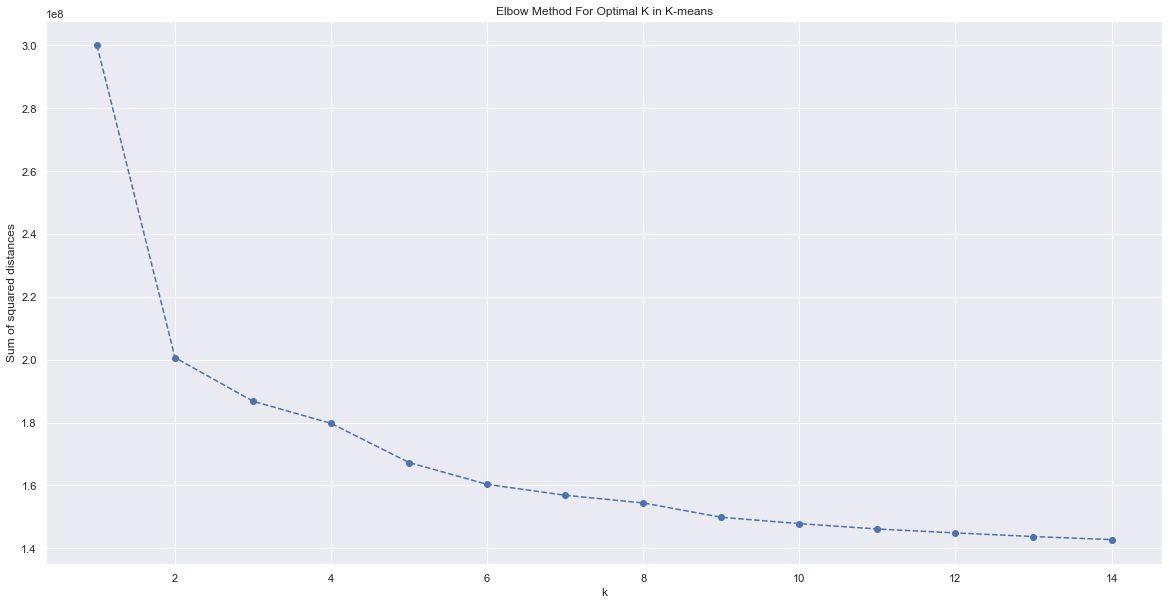

In [342]:
# plot to see elbow
plt.figure(figsize=(6,4))
plt.plot(K, Sum_of_squared_distances, 'o--')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal K in K-means')

From the above chart, we see that k=9 is an appopriate number for K.

In [107]:
# kmeans for clustering with n_clusters=9 and fit the model
km = KMeans(n_clusters=9)
km.fit(population_reduced)

KMeans(n_clusters=9)

In [108]:
# predict population dataset
population_predicted = km.predict(population_reduced)

In [109]:
# create dataframe for the population clusters
population_clustered=pd.DataFrame(population_predicted, columns=["cluster"])

In [110]:
population_clustered.shape

(891221, 1)

In [111]:
# predict customer dataset
customer_predicted = km.predict(customer_reduced)

In [112]:
# create dataframe for customer_predicted
customer_clustered=pd.DataFrame(customer_predicted, columns=["cluster"])

In [113]:
customer_clustered.shape

(191652, 1)

In [114]:
population_clustered.value_counts()

cluster
1          180995
4          175828
3          148960
7          132300
0           99205
5           73562
8           34089
2           31496
6           14786
dtype: int64

In [115]:
customer_clustered.value_counts()

cluster
1          49190
7          45155
4          31773
8          30392
3          30342
0           3188
2           1605
5              7
dtype: int64

In [116]:
pop_clusters = population_clustered.value_counts().reset_index()

In [117]:
pop_clusters.rename(columns={0:'general population'},inplace=True)

In [118]:
pop_clusters

,cluster,general population
0,1,180995
1,4,175828
2,3,148960
3,7,132300
4,0,99205
5,5,73562
6,8,34089
7,2,31496
8,6,14786


In [119]:
pop_clusters['% of share pop'] = pop_clusters['general population']/population_clustered.shape[0]

In [120]:
cust_clusters = customer_clustered.value_counts().reset_index()
cust_clusters.rename(columns={0:'customers'},inplace=True)
cust_clusters['% of share cust'] = cust_clusters['customers']/customer_clustered.shape[0]

In [121]:
all_clusters = pd.merge(pop_clusters, cust_clusters, how = 'left', on = 'cluster')

In [122]:
all_clusters.sort_values(by = '% of share pop',ascending = False)

,cluster,general population,% of share pop,customers,% of share cust
0,1,180995,0.203087,49190.0,0.256663
1,4,175828,0.197289,31773.0,0.165785
2,3,148960,0.167141,30342.0,0.158318
3,7,132300,0.148448,45155.0,0.235609
4,0,99205,0.111314,3188.0,0.016634
5,5,73562,0.082541,7.0,0.000037
6,8,34089,0.038250,30392.0,0.158579
7,2,31496,0.035340,1605.0,0.008375
8,6,14786,0.016591,NaN,NaN


In [123]:
all_clusters.fillna(0,axis=0,inplace=True)

<AxesSubplot:xlabel='cluster'>

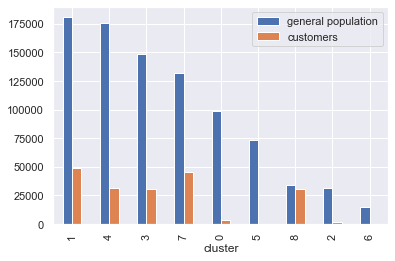

In [124]:
all_clusters[['cluster','general population','customers']].plot(kind="bar", x='cluster')

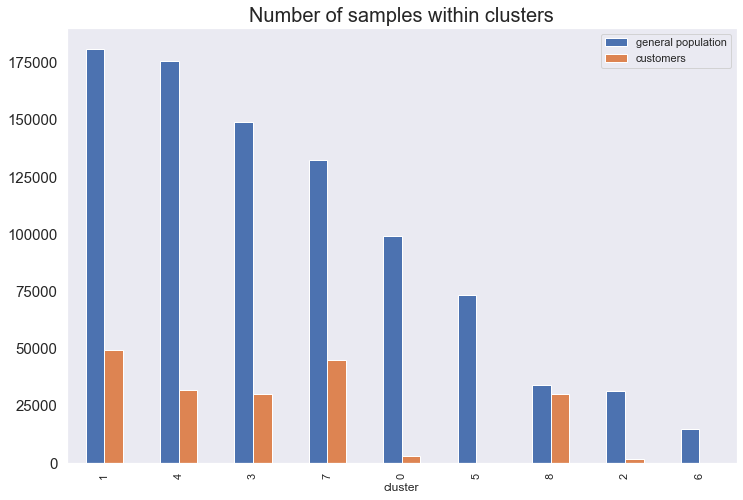

In [125]:
fig, ax1 = plt.subplots(figsize=(12,8))
all_clusters[['cluster','general population','customers']].plot(kind="bar", x='cluster', ax = ax1)

#ax2 = ax1.twinx()    
#ax2.plot('cluster','% of share pop', data = all_clusters, color = 'red', marker = 11, markerfacecolor='None') 
#ax2.plot('cluster','% of share cust', data = all_clusters, color = 'blue', marker = 11,markerfacecolor='None') 

#sns.lineplot(data=all_clusters,ax = ax2, x="cluster", y="% of share pop", markers=True, dashes=False, color = 'blue')
#sns.lineplot(data=all_clusters,ax = ax2, x="cluster", y="% of share cust", markers=True, dashes=False, color = 'red')
#ax2.set_ylabel("% share", fontsize=10, color="blue")
#ax2.legend(loc=(0.2,0.9))

ax1.set_title('Number of samples within clusters', size = 20);
plt.yticks(fontsize=15)
ax1.grid(False)

#plt.legend()
#plt.show();

We see that for the general population the top 3 clusters by share are 1, 4 and 3, while for the customers - 1, 7 and 4. Also the proportion of customers within cluster 8 is quite high - 16% of the customers fall into that cluster, and only 3% of the general population. At the same time we see that there are almost no customers at cluster 0, cluster 5 ,2 and 6. 

In [126]:
cluster_centers = km.cluster_centers_[2]

In [127]:
population_pca_feature_importance.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS

In [128]:
def analyze_component(component,top=3):
    '''
    Given a the PC component, it extracts the features and their weights that mostly contribute to that PC
    
    Input:
    number of PC - integer
    '''
    
    # Extracting features' weight on the desired component:
    weights = list(population_pca.components_[component])
    features = list(pop_scaled.columns)
    
    # Getting the index of ordered weights:
    ordered_idx = np.argsort(weights)[::-1]
    
    # Getting top indexes:
    top_pos_idx = ordered_idx[:top]
    top_neg_idx = ordered_idx[-top:]
    
     # Printing top positive weights on the component:
    print('\nComponent {}'.format(component))
    print('------------')
    print('\n* Top {} Positive Weights:'.format(top))
    print('--------------------------')
    for i in top_pos_idx:
        print('{}: {:.3f}'.format(features[i], weights[i]))
    
    # Printing top negative weights on the component:
    print('\n* Top {} Negative Weights:'.format(top))
    print('--------------------------')
    for j in top_neg_idx[::-1]:
        print('{}: {:.3f}'.format(features[j], weights[j]))

In [129]:
# Creating a function that, given one specific cluster, returns the most important features associated with it:
def cluster_most_important_features(cluster, kmeans = km, top_comp = 3):
    '''
    Given a cluster, it searches for the most important components, and through them, search for 
    the most important features related to those components.
    
    Input:
    cluster: integer indicating the target cluster (0-8);
    kmeans: trained kmeans model
    top_com: number of most important components to be analyzed.
    '''
    # Getting cluster center:
    cluster_centers = kmeans.cluster_centers_[cluster]
    
    # Getting more important components:
    pos_idx = np.argsort(cluster_centers)[::-1]
    pos_idx = pos_idx[:top_comp]
    
    # Analyzing components and extracting their most important features:
    print('Principal Components with Highest Impact on Cluster {}:'.format(cluster))
    print('--------------------------------------------------------')
    for comp in pos_idx:
        analyze_component(comp)

In [130]:
cluster_7 = cluster_most_important_features(7,kmeans = km, top_comp = 3)

Principal Components with Highest Impact on Cluster 7:
--------------------------------------------------------

Component 2
------------

* Top 3 Positive Weights:
--------------------------
KBA05_ANHANG: 0.141
KBA05_SEG6: 0.140
KBA05_MOTRAD: 0.129

* Top 3 Negative Weights:
--------------------------
VK_ZG11: -0.084
KBA13_ANTG3: -0.082
VK_DISTANZ: -0.082

Component 3
------------

* Top 3 Positive Weights:
--------------------------
FINANZ_SPARER: 0.194
CJT_TYP_2: 0.190
CJT_TYP_1: 0.182

* Top 3 Negative Weights:
--------------------------
FINANZ_VORSORGER: -0.183
CJT_TYP_5: -0.182
CJT_TYP_3: -0.173

Component 12
------------

* Top 3 Positive Weights:
--------------------------
LP_FAMILIE_GROB: 0.213
LP_FAMILIE_FEIN: 0.213
LP_LEBENSPHASE_GROB: 0.206

* Top 3 Negative Weights:
--------------------------
D19_KONSUMTYP: -0.219
D19_TELKO_ONLINE_QUOTE_12: -0.181
D19_VERSI_ONLINE_QUOTE_12: -0.160


In [135]:
information[(information['Attribute']=='KOMBIALTER')|(information['Attribute']=='FINANZ_UNAUFFAELLIGER')|(information['Attribute']=='FINANZ_ANLEGER')|(information['Attribute']=='LP_FAMILIE_FEIN')|(information['Attribute']=='LP_FAMILIE_GROB')|(information['Attribute']=='LP_LEBENSPHASE_GROB')]

,Unnamed: 0,Information level,Attribute,Description,Additional notes
7,NaN,Person,FINANZ_ANLEGER,financial typology: investor,NaN
8,NaN,Person,FINANZ_UNAUFFAELLIGER,financial typology: unremarkable,NaN
16,NaN,Person,LP_LEBENSPHASE_GROB,lifestage rough,modelled on different AZ DIAS data
17,NaN,Person,LP_FAMILIE_FEIN,family type fine,NaN
18,NaN,Person,LP_FAMILIE_GROB,family type rough,NaN


In [146]:
information[(information['Attribute']=='D19_GESAMT_DATUM')|(information['Attribute']=='D19_VERSAND_DATUM')|(information['Attribute']=='D19_GESAMT_ONLINE_DATUM')|(information['Attribute']=='D19_GESAMT_ANZ_24')|(information['Attribute']=='D19_GESAMT_ANZ_12')|(information['Attribute']=='D19_VERSAND_ANZ_24')]

,Unnamed: 0,Information level,Attribute,Description,Additional notes
56,NaN,Household,D19_GESAMT_ONLINE_DATUM,actuality of the last transaction with the com...,NaN
57,NaN,Household,D19_GESAMT_DATUM,actuality of the last transaction with the com...,NaN
66,NaN,Household,D19_VERSAND_DATUM,actuality of the last transaction for the segm...,NaN


In [131]:
cluster_8 = cluster_most_important_features(8,kmeans = km, top_comp = 3)

Principal Components with Highest Impact on Cluster 8:
--------------------------------------------------------

Component 0
------------

* Top 3 Positive Weights:
--------------------------
KOMBIALTER: 0.061
FINANZ_UNAUFFAELLIGER: 0.040
FINANZ_ANLEGER: 0.034

* Top 3 Negative Weights:
--------------------------
DSL_FLAG: -0.087
MIN_GEBAEUDEJAHR: -0.087
KBA13_KRSSEG_KLEIN: -0.086

Component 16
------------

* Top 3 Positive Weights:
--------------------------
D19_TELKO_ANZ_24: 0.245
D19_TELKO_ANZ_12: 0.238
KBA05_HERSTTEMP: 0.168

* Top 3 Negative Weights:
--------------------------
D19_TELKO_DATUM: -0.244
D19_TELKO_OFFLINE_DATUM: -0.214
D19_GESAMT_OFFLINE_DATUM: -0.138

Component 12
------------

* Top 3 Positive Weights:
--------------------------
LP_FAMILIE_GROB: 0.213
LP_FAMILIE_FEIN: 0.213
LP_LEBENSPHASE_GROB: 0.206

* Top 3 Negative Weights:
--------------------------
D19_KONSUMTYP: -0.219
D19_TELKO_ONLINE_QUOTE_12: -0.181
D19_VERSI_ONLINE_QUOTE_12: -0.160


In [148]:
cluster_8 = cluster_most_important_features(8,kmeans = km, top_comp = 3)

Principal Components with Highest Impact on Cluster 8:
--------------------------------------------------------

Component 2
------------

* Top 3 Positive Weights:
--------------------------
KBA05_ANHANG: 0.141
KBA05_SEG6: 0.140
KBA05_MOTRAD: 0.129

* Top 3 Negative Weights:
--------------------------
VK_ZG11: -0.084
KBA13_ANTG3: -0.082
VK_DISTANZ: -0.082

Component 3
------------

* Top 3 Positive Weights:
--------------------------
FINANZ_SPARER: 0.194
CJT_TYP_2: 0.190
CJT_TYP_1: 0.182

* Top 3 Negative Weights:
--------------------------
FINANZ_VORSORGER: -0.183
CJT_TYP_5: -0.182
CJT_TYP_3: -0.173

Component 12
------------

* Top 3 Positive Weights:
--------------------------
LP_FAMILIE_GROB: 0.213
LP_FAMILIE_FEIN: 0.213
LP_LEBENSPHASE_GROB: 0.206

* Top 3 Negative Weights:
--------------------------
D19_KONSUMTYP: -0.219
D19_TELKO_ONLINE_QUOTE_12: -0.181
D19_VERSI_ONLINE_QUOTE_12: -0.160


## 3. Supervised Learning

Udacity_MAILOUT_052018_TRAIN.csv: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
Udacity_MAILOUT_052018_TEST.csv: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

In [4]:
mailout_train = pd.read_csv(os.getcwd()+'/src/data/raw_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

mailout_test = pd.read_csv(os.getcwd()+'/src/data/raw_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

### 3.1. Exploratory analysis on the training set

In [5]:
mailout_train.shape

(42962, 367)

In [139]:
mailout_train['RESPONSE'].value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

We have highly imbalanced training dataset. That is why we use ROC AUC for evaluation based on True positive and False positive rates.

In [7]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [8]:
mailout_test['LNR'].nunique()

42833

In [157]:
#check for null values
missing_values = mailout_train.isnull().sum()/mailout_train.shape[0]
missing_values.sort_values(ascending=False,inplace=True)
missing_values.head(30)

ALTER_KIND4        0.999046
ALTER_KIND3        0.995950
ALTER_KIND2        0.982403
ALTER_KIND1        0.953727
KK_KUNDENTYP       0.589265
EXTSEL992          0.371212
W_KEIT_KIND_HH     0.225269
HH_DELTA_FLAG      0.225269
KBA05_KRSOBER      0.201294
KBA05_KRSHERST3    0.201294
KBA05_KRSHERST2    0.201294
KBA05_CCM4         0.201294
KBA05_KRSHERST1    0.201294
KBA05_KRSAQUOT     0.201294
KBA05_HERST5       0.201294
KBA05_HERST4       0.201294
KBA05_HERST3       0.201294
KBA05_HERST2       0.201294
KBA05_HERST1       0.201294
KBA05_GBZ          0.201294
KBA05_FRAU         0.201294
KBA05_DIESEL       0.201294
KBA05_CCM1         0.201294
KBA05_CCM3         0.201294
KBA05_CCM2         0.201294
KBA05_KRSZUL       0.201294
KBA05_BAUMAX       0.201294
KBA05_AUTOQUOT     0.201294
KBA05_ANTG4        0.201294
KBA05_ANTG3        0.201294
dtype: float64

In [159]:
#find columns with the same value
col_list = []
for col in mailout_train.columns:
    if mailout_train[col].nunique()==1:
        col_list.append(col)

In [160]:
col_list

[]

In [161]:
# check for duplicated features in the whole dataset:

# create an empty dictionary, where we will store 
# the groups of duplicates
duplicated_feat_pairs = {}

# create an empty list to collect features
# that were found to be duplicated
_duplicated_feat = []


# iterate over every feature in our dataset:
for i in range(0, len(mailout_train.columns)):
    
    # this bit helps me understand where the loop is at:
    if i % 10 == 0:  
        print(i)
    
    # choose 1 feature:
    feat_1 = mailout_train.columns[i]
    
    # check if this feature has already been identified
    # as a duplicate of another one. If it was, it should be stored in
    # our _duplicated_feat list.
    
    # If this feature was already identified as a duplicate, we skip it, if
    # it has not yet been identified as a duplicate, then we proceed:
    if feat_1 not in _duplicated_feat:
    
        # create an empty list as an entry for this feature in the dictionary:
        duplicated_feat_pairs[feat_1] = []

        # now, iterate over the remaining features of the dataset:
        for feat_2 in mailout_train.columns[i + 1:]:

            # check if this second feature is identical to the first one
            if mailout_train[feat_1].equals(mailout_train[feat_2]):

                # if it is identical, append it to the list in the dictionary
                duplicated_feat_pairs[feat_1].append(feat_2)
                
                # and append it to our monitor list for duplicated variables
                _duplicated_feat.append(feat_2)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360


In [162]:
# print the features with its duplicates

# iterate over every feature in our dict:
for feat in duplicated_feat_pairs.keys():
    
    # if it has duplicates, the list should not be empty:
    if len(duplicated_feat_pairs[feat]) > 0:

        # print the feature and its duplicates:
        print(feat, duplicated_feat_pairs[feat])
        print()

KBA13_FAB_SONSTIGE ['KBA13_HERST_SONST']



In [163]:
mailout_train.describe(include='object')

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
count,35074,35074.0,35074.0,35378,35185,35185
unique,45,19.0,43.0,35,1599,2
top,6B,6.0,24.0,D19_UNBEKANNT,1992-02-10 00:00:00,W
freq,2452,3884.0,3024.0,10276,18156,26752


In [164]:
mailout_test.describe(include='object')

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
count,35093,35093.0,35093.0,35307,35206,35206
unique,45,19.0,43.0,35,1608,2
top,6B,6.0,24.0,D19_UNBEKANNT,1992-02-10 00:00:00,W
freq,2497,3588.0,2796.0,10115,18096,26773


### 3.2.Prepare data for modelling

So we see that we need to perform the same data cleaning tasks as in the first part of the project - remove the 6th columns with predominantly missing values, remove 1 duplicate feature, transform the categorical variable in the same way we did within the population dataset: remove CAMEO_DEU_2015, CAMEO_INTL_2015, D19_LETZTER_KAUF_BRANCHE, EINGEFUEGT_AM  /due to high cardinality and lack of description/, transformation of CAMEO_DEUG_2015 to unify its values and creating a dummy variable out of  OST_WEST_KZ.

In [6]:
def process_df (df): 
    '''
    fuction to return preprocessed df ready for transformation within a pipeline
    '''
    #drop columns 
    df.drop(columns = {'ALTER_KIND4', 'ALTER_KIND3','ALTER_KIND2','ALTER_KIND1','KK_KUNDENTYP', 'EXTSEL992','KBA13_HERST_SONST',
                      'CAMEO_DEU_2015','CAMEO_INTL_2015','D19_LETZTER_KAUF_BRANCHE','EINGEFUEGT_AM'},axis=1, inplace=True)
    df['CAMEO_DEUG_2015'].fillna(-1,axis=0, inplace=True)
    df['CAMEO_DEUG_2015'] = np.where(df['CAMEO_DEUG_2015']=='X',-1,df['CAMEO_DEUG_2015'])
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].astype(int)
    
    
    #replace all missing values with -01
    col_list = ['ALTERSKATEGORIE_GROB', 'ALTER_HH', 'CAMEO_DEUG_2015', 'D19_BANKEN_DATUM', 'D19_BANKEN_OFFLINE_DATUM',
            'D19_BANKEN_ONLINE_DATUM','D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_DATUM', 'D19_GESAMT_OFFLINE_DATUM',
            'D19_GESAMT_ONLINE_DATUM', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP', 'D19_TELKO_DATUM', 'D19_TELKO_OFFLINE_DATUM', 
            'D19_TELKO_ONLINE_DATUM', 'D19_VERSAND_DATUM', 'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM',
            'D19_VERSAND_ONLINE_QUOTE_12', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB','LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB']

    for col in col_list:
        df[col] = np.where(df[col]==0,-1,df[col])
    
     #replace all missing values with -1
    col_list_2 = ['GREEN_AVANTGARDE', 'SHOPPER_TYP']
    for col in col_list_2:
        df[col] = np.where(df[col]==9,-1,df[col])
    #encode categorical variable
    df_enc = pd.get_dummies(df['OST_WEST_KZ'])
    df_new = pd.merge(df,df_enc,right_index=True,left_index=True)
    df_new.drop(columns={'LNR','OST_WEST_KZ'},axis=1,inplace=True)
    
    return df_new

In [7]:
X_train = process_df(mailout_train)

In [8]:
X_train.shape

(42962, 356)

In [9]:
#process test data
X_test = process_df(mailout_test)

In [10]:
X_test.shape

(42833, 355)

In [11]:
#Split the X from Y for the classification part
y_train = X_train['RESPONSE'].copy()
X_train.drop(['RESPONSE'], axis = 1, inplace = True)

In [12]:
y_train.unique()

array([0, 1])

### 3.3.Select a model with best performance
The evaluation will be based on the whole train data. For further hyperparameter tuning, I will use GridsearchCV and cross-validation technique.

#### GridSearch Cross Validation for the best Classification parameters

We will run a Cross Validation GridSearch over the most common classification algorithms, to choose the one the scores highest by ROC AUC metric. We will use Logistic Regression, GradientBoosting, Adaboosting, SVC.

In [45]:
#Logistic regression classifier

pipe = Pipeline([
    ('impute', SimpleImputer(strategy= 'constant', fill_value = -1)),
    ('scale', StandardScaler()), 
    ('clf', LogisticRegression(random_state=0))
                ])

param_grid = {'clf__penalty': ['l1','l2'],
              'clf__C': [0.1,1,10]
             }

cv = GridSearchCV(pipe, param_grid, scoring='roc_auc', cv=5, n_jobs=-1)

cv.fit(X_train,y_train)

# and we print the best score over the train set
print(("best roc-auc from grid search for Logistic Regression: %.3f"
       % cv.score(X_train, y_train)))
warnings.filterwarnings('ignore')


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

best roc-auc from grid search for Logistic Regression: 0.799


In [25]:
#gradient boosting classifier

pipe = Pipeline([
    ('impute', SimpleImputer(strategy= 'constant', fill_value = -1)),
    ('scale', StandardScaler()), 
    ('clf', GradientBoostingClassifier(random_state=0))
                ])

param_grid = {'clf__loss': ['log_loss'],
              'clf__max_depth': [None, 1, 3],
              'clf__learning_rate': [0.1],
              'clf__n_estimators': [100,150]
             }

cv = GridSearchCV(pipe, param_grid, scoring='roc_auc', cv=5, n_jobs=-1)

cv.fit(X_train,y_train)

# and we print the best score over the train set
print(("best roc-auc from grid search for Gradient Boosting: %.3f"
       % cv.score(X_train, y_train)))

warnings.filterwarnings('ignore')

In [32]:
# and we print the best score over the train set
print(("best roc-auc from grid search: %.3f"
       % cv.score(X_train, y_train)))

best roc-auc from grid search: 0.804


In [37]:
cv.cv_results_['mean_test_score']

array([0.53198437, 0.68715322, 0.76737346, 0.770735  , 0.75827931,
       0.7530422 ])

In [36]:
cv.best_params_

{'clf__learning_rate': 0.1,
 'clf__loss': 'log_loss',
 'clf__max_depth': 1,
 'clf__n_estimators': 150}

In [46]:
#ada boosting classifier

pipe = Pipeline([
    ('impute', SimpleImputer(strategy= 'constant', fill_value = -1)),
    ('scale', StandardScaler()), 
    ('clf', AdaBoostClassifier(random_state=0))
                ])

param_grid = {
              'clf__learning_rate': [0.1,1],
              'clf__n_estimators': [50,100,150]
             }

cv = GridSearchCV(pipe, param_grid, scoring='roc_auc', cv=5, n_jobs=-1)

cv.fit(X_train,y_train)

# and we print the best score over the train set
print(("best roc-auc from grid search for Ada Boosting: %.3f"
       % cv.score(X_train, y_train)))

best roc-auc from grid search for Ada Boosting: 0.793


In [47]:
#Linear SVC

pipe = Pipeline([
    ('impute', SimpleImputer(strategy= 'constant', fill_value = -1)),
    ('scale', StandardScaler()), 
    ('clf', LinearSVC(random_state=0))
                ])

param_grid = {
              'clf__C': [0.1,1,10],
              'clf__penalty': ['l2','l1']
             }

cv = GridSearchCV(pipe, param_grid, scoring='roc_auc', cv=5, n_jobs=-1)

cv.fit(X_train,y_train)

# and we print the best score over the train set
print(("best roc-auc from grid search for SVM: %.3f"
       % cv.score(X_train, y_train)))

warnings.filterwarnings('ignore')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increas

best roc-auc from grid search for SVM: 0.799


All of the 4 algorithms show very close scores, around 0.8. THe highest score is for the Gradient Boosting Classifier with number of boosting stages 150. The other best parameters fit to the default parameters of the scikit learn algorithm.

### 3.4. Final model for calculation of the RESPONSE on the test set

In [13]:
pipe = Pipeline([
    ('impute', SimpleImputer(strategy= 'constant', fill_value = -1)),
    ('scale', StandardScaler()), 
    ('clf', GradientBoostingClassifier(random_state=0, n_estimators = 150))
                ])

# train classifier
pipe.fit(X_train,y_train)

# predict on test data
y_test_pred = pipe.predict(X_test)

In [22]:
#plot confusion matrix for the train dataset
y_train_pred = pipe.predict(X_train)

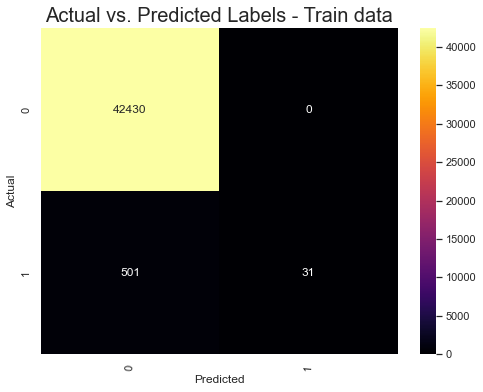

In [25]:
conf_mat = confusion_matrix(y_train, y_train_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, cmap= 'inferno',fmt='d',xticklabels=y_train.unique(), yticklabels=y_train.unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
ax.tick_params(axis='x', grid_color='r', grid_alpha=0.5, labelrotation =85)
ax.set_title("Actual vs. Predicted Labels - Train data",size=20)
plt.show()

In [26]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     42430
           1       1.00      0.06      0.11       532

    accuracy                           0.99     42962
   macro avg       0.99      0.53      0.55     42962
weighted avg       0.99      0.99      0.98     42962



In [52]:
# save the model to pickle
filename = 'src/models/gbmclassifier.pkl'
pickle.dump(pipe, open(filename, 'wb'))

In [14]:
y_test_prob_pred = pipe.predict_proba(X_test)[:, 1]

In [15]:
y_test_prob_pred

array([0.05476925, 0.03093377, 0.00445258, ..., 0.01393935, 0.07603029,
       0.02084074])

In [16]:
y_test_pred

array([0, 0, 0, ..., 0, 0, 0])

In [17]:
# Creating a DF with the Response:
y_test_calc = pd.DataFrame()
y_test_calc['RESPONSE'] =pipe.predict_proba(X_test)[:, 1]

In [18]:
y_test_calc['RESPONSE'].head()

0    0.054769
1    0.030934
2    0.004453
3    0.005309
4    0.001880
Name: RESPONSE, dtype: float64

In [19]:
y_test_final = pd.merge(mailout_test['LNR'],y_test_calc, how = 'left', right_index=True, left_index=True)

In [20]:
y_test_final.head()

,LNR,RESPONSE
0,1754,0.054769
1,1770,0.030934
2,1465,0.004453
3,1470,0.005309
4,1478,0.001880


In [21]:
y_test_final[y_test_final['RESPONSE']>0.5].count()

LNR         15
RESPONSE    15
dtype: int64

There are only 15 people that are suggested as potential customers to Arvato. 

In [85]:
y_test_final.to_csv('src/models/gbc_pred.csv', header = True, index = False)

## 4. Conclusion

Ideas for improvement:
1) Data is highly imbalanced - we have less than 1% of the data with positive labels - being customers. So there is a huge opportunity for improvement if we balance the data with oversampling techniques. 
2) Feature engineering:
- removing additonal columns with missing data
- columns that I have removed could be feature engineered for lower cardinality levels , in order to be included in the analysis
- another technique for imputing of missing values /mean/
3) Feature selection can be performed to reduce the number of the features that are fed into the Gradient Boosting algoritm.